# AEWS Python Notebook 06: dealing with multiple same-day datasets

**Author**: Eric Lehmann, CSIRO Data61  
**Date**: 02 May 2016

**Note**: The Python code below is "rudimentary" etc. etc. Priority is here given to code interpretability rather than execution efficiency.

**Note**: this notebook should be accessible and viewable at [https://github.com/eric542/agdc_v2/tree/master/notebooks](https://github.com/eric542/agdc_v2/tree/master/notebooks).

## Summary

In this notebook, we introduce / review the following concepts:

* loading Landsat data
* checking the dates available in the time series
* "removing" duplicates

## Preliminaries

Landsat data from one overpass is split into scenes during early stages of processing by GA. The data in each scene is assigned a time stamp according to when the scene centre was captured, meaning that tiles located at the scene breaks end up with multiple time slices separated by few seconds only. 

It is likely that this "issue" will be ironed out when the AGDC v2.0 API is formally realeased. In the meantime, there are some helper functions in the v2.0 API that can be used to assist with this, and this notebook was originally written to test this functionality.

This (Jupyter) notebook was written for use on the NCI's VDI system, with the following pre-loaded module:

```
 $ module use /g/data/v10/public/modules/modulefiles --append
 $ module load agdc-py2-dev
```

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray

from pprint import pprint
from __future__ import print_function

from pylab import rcParams
rcParams['figure.figsize'] = (10,10)   # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False   # disable scalar formatter / offset in axes labels

import datacube.api   # import the AGDC v2 API, with pre-loaded 'agds-py2-dev' (or similar) NCI module

from datetime import datetime
from datacube.analytics.analytics_engine import AnalyticsEngine
from datacube.execution.execution_engine import ExecutionEngine
from datacube.analytics.utils.analytics_utils import plot

## Loading Landsat data and checking available dates


In [2]:
dimensions = { 'longitude': {'range': (149.06, 149.17)},   # LBG
               'latitude':  {'range': (-35.33, -35.27)},
               'time':      { 'range': ((1990, 1, 1), (1990, 4, 5))} }

ae = AnalyticsEngine()
ee = ExecutionEngine()

aeB2 = ae.create_array(('LANDSAT_5', 'NBAR'), ['band_20'], dimensions, 'aeB2')
aeB3 = ae.create_array(('LANDSAT_5', 'NBAR'), ['band_30'], dimensions, 'aeB3')
aeWQ = ae.apply_expression([aeB2, aeB3], '((array1 + array2) * 0.5)', 'aeWQ')
ee.execute_plan(ae.plan)

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


Let's investigate in more detail the dates available for this dataset... Note that we have to be careful when dealing with UTC vs. local dates (e.g. two time slices a few seconds apart could be deemed from another day when using UTC+0000
dates, whereas they should just have a different hour on the same day in local time!). 

In [3]:
L5_dates = ee.cache['aeWQ']['array_indices']['time']
print( L5_dates[:8], "\n ... \n", L5_dates[-7:], "\n" )
print( L5_dates.dtype )

['1990-03-03T10:11:16.000000000+1100' '1990-03-03T10:11:39.000000000+1100'
 '1990-04-04T09:10:42.000000000+1000'] 
 ... 
 ['1990-03-03T10:11:16.000000000+1100' '1990-03-03T10:11:39.000000000+1100'
 '1990-04-04T09:10:42.000000000+1000'] 

datetime64[ns]


Note how the dates here are in local format (in +11h00 or +10h00 time zone). If we were, e.g., to extract these dates into strings, the `np.datetime64[ns]` format might automatically translate to UTC+0000 time.

In [4]:
tmp = L5_dates.astype('str')
print( tmp[:8], "\n ... \n", tmp[-7:], "\n" )

['1990-03-02T23:11:16.000000000Z' '1990-03-02T23:11:39.000000000Z'
 '1990-04-03T23:10:42.000000000Z'] 
 ... 
 ['1990-03-02T23:11:16.000000000Z' '1990-03-02T23:11:39.000000000Z'
 '1990-04-03T23:10:42.000000000Z'] 



From this (see e.g. the first 2 dates), it is not unthinkable that data from the same day in the local time zone (e.g. 1990-03-03) might end up in two different days if considered in UTC+00h00 time. Therefore, we want to use the dates (Y/M/D format) from the local time zone instead. The following code seems to do the trick...

In [5]:
n_dates = len( L5_dates )
strL5_dates = np.zeros(n_dates).astype('str')
for ii in range(n_dates):
    strL5_dates[ii] = str( L5_dates[ii] )[:10]
print( strL5_dates[:10], "\n... \n", strL5_dates[-7:], "\n" )

['1990-03-03' '1990-03-03' '1990-04-04'] 
... 
 ['1990-03-03' '1990-03-03' '1990-04-04'] 



So the correct days (in local time, not UTC+0000) are extracted. Now we can compare them and check how many single dates we have in total:

In [6]:
print( "There are", n_dates, "individual time stamps in the series", 
       "between", str( ee.cache['aeWQ']['array_output']['result_min'][0] )[:10], "and", 
       str( ee.cache['aeWQ']['array_output']['result_max'][0] )[:10] )

n_single_dates = len( np.unique( strL5_dates ) )
print( "Of the", n_dates, "time stamps, only", n_single_dates, "are unique dates.")

There are 3 individual time stamps in the series between 1990-03-03 and 1990-04-04
Of the 3 time stamps, only 2 are unique dates.


## "Removing" duplicated dates

Obviously, we have a number of duplicated dates in the dataset, i.e. a number of Landsat images that have been acquired on the same day (due to effects resulting from being at the edge of a scene). As mentioned above, some "helper" functions currently exist (under development!), although I have been unsuccessful in getting those to work in conjunction with the Analytics / Execution engines. Consequently, we'll have to "manually" deal with this issue...

But first, a quick example to illustrate what's happening...

In [7]:
WQ_TS_xarr = ee.cache['aeWQ']['array_result']['aeWQ'].copy()
WQ_TS_arr = WQ_TS_xarr.values   # Time series dataset of WQ arrays

array([[  898. ,   837.5,   772.5, ...,   480. ,   522. ,   487. ],
       [  849. ,   785. ,   746. , ...,   451.5,   484. ,   466.5],
       [  813. ,   774.5,   778.5, ...,   438.5,   461.5,   491. ],
       ..., 
       [    nan,     nan,     nan, ...,  1718. ,  2108.5,  2132.5],
       [    nan,     nan,     nan, ...,  1959. ,  2176.5,  2036.5],
       [    nan,     nan,     nan, ...,  1972.5,  1959. ,  1947.5]])

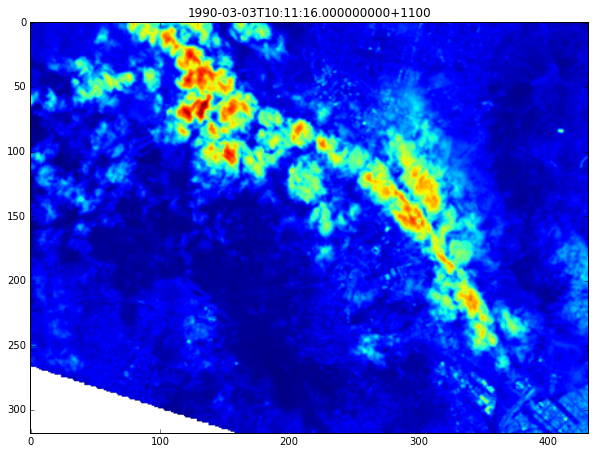

In [8]:
plt.imshow(WQ_TS_arr[0]); plt.title( L5_dates[0] )
WQ_TS_arr[0]

array([[  887. ,   832.5,   793. , ...,   499.5,   531. ,   494.5],
       [  842.5,   778.5,   775.5, ...,   472. ,   506. ,   486. ],
       [  824.5,   785.5,   796. , ...,   464.5,   495. ,   514. ],
       ..., 
       [ 1803.5,  1603.5,  1419. , ...,  1747. ,  2154.5,  2102. ],
       [ 1982. ,  1794.5,  1573. , ...,  1980.5,  2168.5,  2025.5],
       [ 2071. ,  1897.5,  1688.5, ...,  1952. ,  1927. ,  1934. ]])

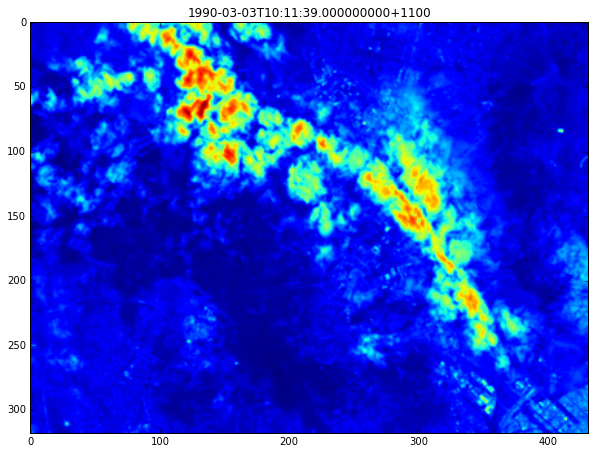

In [9]:
plt.imshow(WQ_TS_arr[1]); plt.title( L5_dates[1] )
WQ_TS_arr[1]

So the above example shows that we have 2 **completely different** datasets for the same date (1990-03-03)! The data looks the same, but the individual arrays clearly show that **all** the data values are different (e.g. index [0,0] in the arrays corresponds to the top-left image pixels). 

Also, note here that the 2nd image is complete, in that there are no missing values as in the first one. This is not general, and we could be dealing with 2 disjoint same-day datasets that both have NaN's in different parts of the regions of interst. We'll check that kind of example later on in this notebook.

Based on this, the best thing to do would be to fill in the NaN's from one image with the non-NaN values from the other. The piece of code below is written to that effect. It simply detects the duplicated dates, determines which date has most data (i.e. the lowest amount of NaN's), and if necessary, fills in the NaN's in that date with data from the other (duplicated) date. 

_**Note:** This is partly a **hack** which works OK, but will (hopefully) ultimately be sorted out directly through AGDC v2.0 API functions!_

In [10]:
rem_ind = np.zeros(n_dates).astype('bool')   # keep track of which duplicated dates to remove

for ind in range(1,n_dates):
    dup_ind = np.where( strL5_dates[:ind]==strL5_dates[ind] )[0]   # check for duplicated date up to current index
    if len( dup_ind )!=0:   # found (at least) one duplicate
        dup_ind = dup_ind[0]   # only use the first index if multiple dates returned
        rem_ind[ind] = True    # remove current date index
        
        ind_n_nans = np.sum( np.isnan( WQ_TS_arr[ind] ) )   # nr of NaN pixels in each image
        dup_n_nans = np.sum( np.isnan( WQ_TS_arr[dup_ind] ) )
        
        if ind_n_nans==0:   # current data has no NaN's, use it instead of duplicate date (copy it to lowest index)
            WQ_TS_arr[dup_ind] = WQ_TS_arr[ind]
        elif dup_n_nans!=0:   # if duplicate date has no NaN's: do nothing (use it instead of current date)
            if dup_n_nans<ind_n_nans:   # duplicate date has less NaN's: fill it in with current data
                tmp = np.where( np.isnan(WQ_TS_arr[dup_ind]) )
                WQ_TS_arr[dup_ind][tmp] = WQ_TS_arr[ind][tmp]
            else:   # dup_n_nans>=ind_n_nans -- duplicate date has more NaN's: use it to fill in current data
                tmp = np.where( np.isnan(WQ_TS_arr[ind]) )
                WQ_TS_arr[ind][tmp] = WQ_TS_arr[dup_ind][tmp]
                WQ_TS_arr[dup_ind] = WQ_TS_arr[ind]   # save results to lowest date index

unique_WQ_TS_arr = WQ_TS_arr[~rem_ind]
unique_strL5_dates = strL5_dates[ ~rem_ind ]

So, for all single-day images in the dataset, the code above has merged them (filling in data where appropriate) and extracted the relevant dates. Let's check that we have the correct dates:

In [11]:
( np.unique( strL5_dates )==unique_strL5_dates ).all()

True

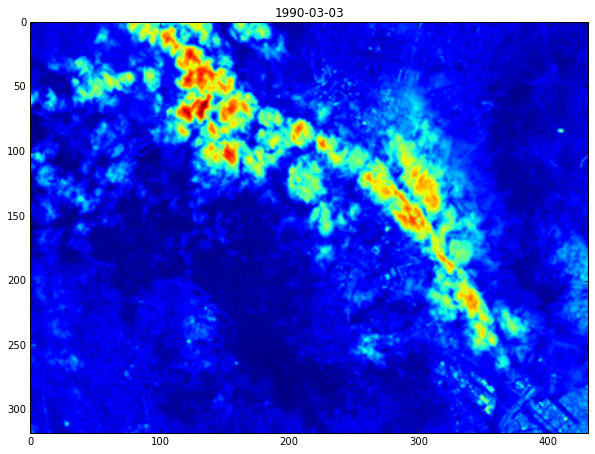

In [12]:
plt.imshow(unique_WQ_TS_arr[0]); plt.title( unique_strL5_dates[0] );

The date 1990-03-03 now correctly contains the data without missing values, and the second date in the new dataset (below) correctly has the next available date.

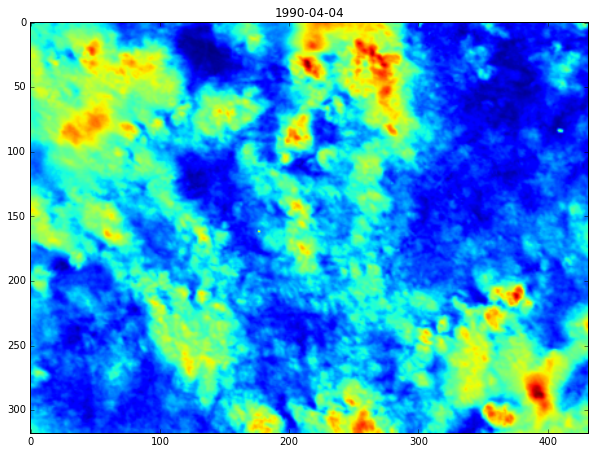

In [13]:
plt.imshow(unique_WQ_TS_arr[1]); plt.title( unique_strL5_dates[1] );

# Saving to NetCDF

In [35]:
# Massaging to emulate final dataset as Numpy arrays
# time_coords = ee.cache['aeWQ']['array_result']['aeWQ'].coords['time'].values
x_coords = ee.cache['aeWQ']['array_result']['aeWQ'].coords['x'].values
y_coords = ee.cache['aeWQ']['array_result']['aeWQ'].coords['y'].values

unique_WQ_TS_arr

array([[[  887. ,   832.5,   793. , ...,   499.5,   531. ,   494.5],
        [  842.5,   778.5,   775.5, ...,   472. ,   506. ,   486. ],
        [  824.5,   785.5,   796. , ...,   464.5,   495. ,   514. ],
        ..., 
        [ 1803.5,  1603.5,  1419. , ...,  1747. ,  2154.5,  2102. ],
        [ 1982. ,  1794.5,  1573. , ...,  1980.5,  2168.5,  2025.5],
        [ 2071. ,  1897.5,  1688.5, ...,  1952. ,  1927. ,  1934. ]],

       [[ 2719.5,  2761.5,  2717. , ...,  2875.5,  2723.5,  2580. ],
        [ 2770. ,  2788. ,  2768.5, ...,  3254. ,  3028.5,  2781. ],
        [ 2829.5,  2818.5,  2820.5, ...,  3282.5,  2900. ,  2616. ],
        ..., 
        [ 3181. ,  3033. ,  2931.5, ...,  3320. ,  3365.5,  3416. ],
        [ 3115.5,  3046.5,  2948.5, ...,  3513.5,  3500. ,  3560.5],
        [ 3070.5,  3066.5,  3041. , ...,  3675. ,  3735. ,  3765.5]]])

In [34]:
unique_WQ_TS_xarr = xarray.DataArray(unique_WQ_TS_arr,
                                     dims=['time', 'y', 'x'],
                                     coords={'time': unique_strL5_dates, 'x': x_coords, 'y': y_coords},
                                     name='WQ')
unique_WQ_TS_xdataset = unique_WQ_TS_xarr.to_dataset(name='WQ_dataset')
xarray.save_mfdataset([unique_WQ_TS_xdataset], ['xarray.nc'])

## With PQ-masked data

Let's summarise the above procedure, this time also using PQ-masked Landsat...

In [14]:
dimensions = { 'longitude': {'range': (149.06, 149.17)},   # LBG
               'latitude':  {'range': (-35.33, -35.27)},
               'time':      { 'range': ((1990, 1, 1), (1991, 1, 1))} }

ae = AnalyticsEngine()
ee = ExecutionEngine()

aeB2 = ae.create_array(('LANDSAT_5', 'NBAR'), ['band_20'], dimensions, 'aeB2')
aeB3 = ae.create_array(('LANDSAT_5', 'NBAR'), ['band_30'], dimensions, 'aeB3')
aePQ = ae.create_array(('LANDSAT_5', 'PQ'), ['band_pixelquality'], dimensions, 'aePQ')
aeWQ = ae.apply_expression([aeB2, aeB3], '((array1 + array2) * 0.5)', 'aeWQ')
aeWQ_PQmsk = ae.apply_expression([aeWQ, aePQ], 'array1{array2}', 'aeWQ_PQmsk')
ee.execute_plan(ae.plan)

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


In [15]:
L5_dates = ee.cache['aeWQ_PQmsk']['array_indices']['time']
n_dates = len( L5_dates )
strL5_dates = np.zeros(n_dates).astype('str')
for ii in range(n_dates):
    strL5_dates[ii] = str( L5_dates[ii] )[:10]

In [16]:
WQ_TS_xarr = ee.cache['aeWQ_PQmsk']['array_result']['aeWQ_PQmsk'].copy()
WQ_TS_arr = WQ_TS_xarr.values   # Time series dataset of WQ arrays

Checking the "original" masked dataset...

array([[  898. ,   837.5,   772.5, ...,   480. ,   522. ,   487. ],
       [  849. ,   785. ,   746. , ...,   451.5,   484. ,   466.5],
       [  813. ,   774.5,   778.5, ...,   438.5,   461.5,   491. ],
       ..., 
       [    nan,     nan,     nan, ...,  1718. ,  2108.5,  2132.5],
       [    nan,     nan,     nan, ...,  1959. ,  2176.5,  2036.5],
       [    nan,     nan,     nan, ...,  1972.5,  1959. ,  1947.5]])

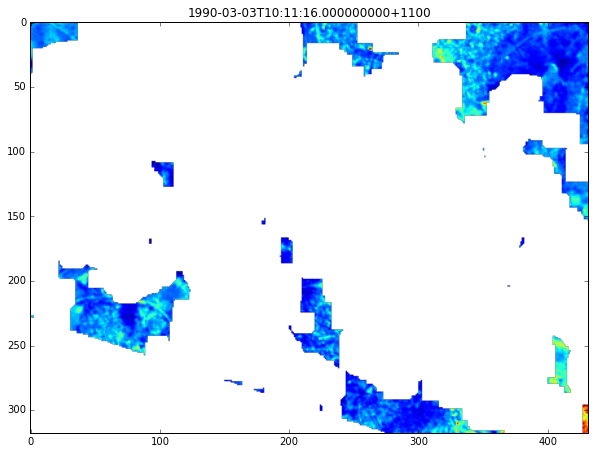

In [17]:
plt.imshow(WQ_TS_arr[0]); plt.title( L5_dates[0] )
WQ_TS_arr[0]

array([[  887. ,   832.5,   793. , ...,   499.5,   531. ,   494.5],
       [  842.5,   778.5,   775.5, ...,   472. ,   506. ,   486. ],
       [  824.5,   785.5,   796. , ...,   464.5,   495. ,   514. ],
       ..., 
       [    nan,     nan,     nan, ...,  1747. ,  2154.5,  2102. ],
       [    nan,     nan,     nan, ...,  1980.5,  2168.5,  2025.5],
       [    nan,     nan,     nan, ...,  1952. ,  1927. ,  1934. ]])

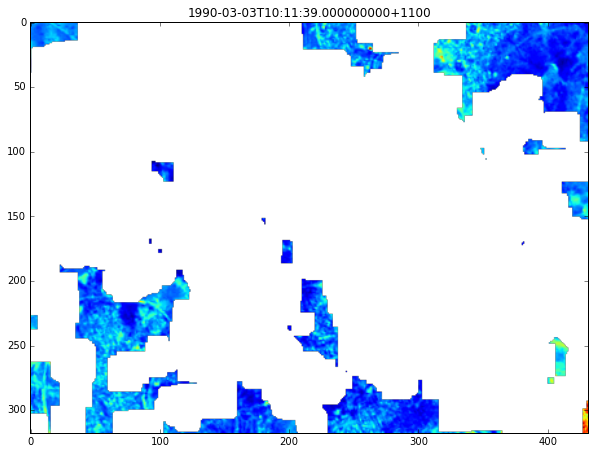

In [18]:
plt.imshow(WQ_TS_arr[1]); plt.title( L5_dates[1] )
WQ_TS_arr[1]

Removing duplicated dates...

In [19]:
rem_ind = np.zeros(n_dates).astype('bool')   # keep track of which duplicated dates to remove

for ind in range(1,n_dates):
    dup_ind = np.where( strL5_dates[:ind]==strL5_dates[ind] )[0]   # check for duplicated date up to current index
    if len( dup_ind )!=0:   # found (at least) one duplicate
        dup_ind = dup_ind[0]   # only use the first index if multiple dates returned
        rem_ind[ind] = True    # remove current date index
        
        ind_n_nans = np.sum( np.isnan( WQ_TS_arr[ind] ) )   # nr of NaN pixels in each image
        dup_n_nans = np.sum( np.isnan( WQ_TS_arr[dup_ind] ) )
        
        if ind_n_nans==0:   # current data has no NaN's, use it instead of duplicate date (copy it to lowest index)
            WQ_TS_arr[dup_ind] = WQ_TS_arr[ind]
        elif dup_n_nans!=0:   # if duplicate date has no NaN's: do nothing (use it instead of current date)
            if dup_n_nans<ind_n_nans:   # duplicate date has less NaN's: fill it in with current data
                tmp = np.where( np.isnan(WQ_TS_arr[dup_ind]) )
                WQ_TS_arr[dup_ind][tmp] = WQ_TS_arr[ind][tmp]
            else:   # dup_n_nans>=ind_n_nans -- duplicate date has more NaN's: use it to fill in current data
                tmp = np.where( np.isnan(WQ_TS_arr[ind]) )
                WQ_TS_arr[ind][tmp] = WQ_TS_arr[dup_ind][tmp]
                WQ_TS_arr[dup_ind] = WQ_TS_arr[ind]   # save results to lowest date index

unique_WQ_TS_arr = WQ_TS_arr[~rem_ind]
unique_strL5_dates = strL5_dates[ ~rem_ind ]

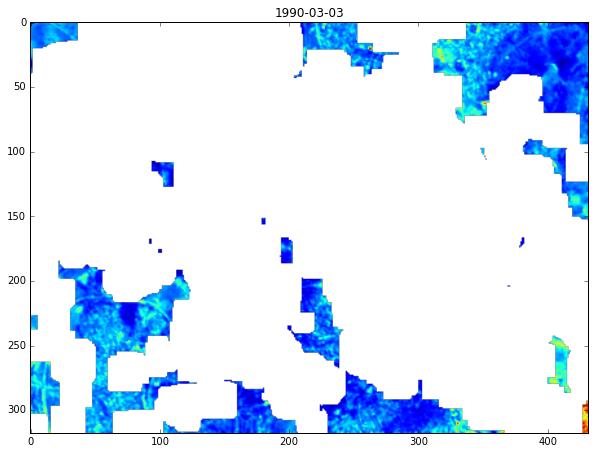

In [20]:
plt.imshow(unique_WQ_TS_arr[0]); plt.title( unique_strL5_dates[0] );

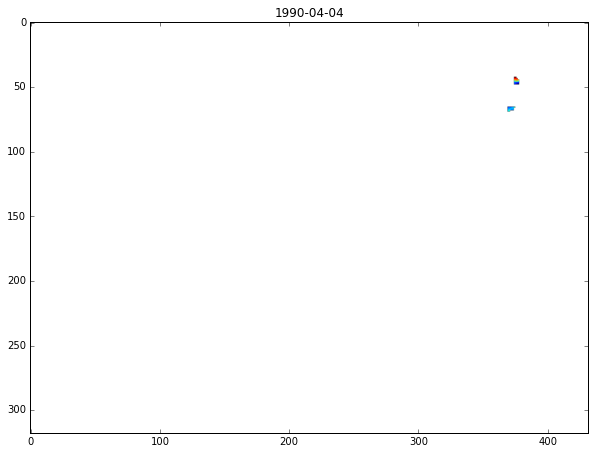

In [21]:
plt.imshow(unique_WQ_TS_arr[1]); plt.title( unique_strL5_dates[1] );

## Double-checking...

We should ensure that the above works when we have a two single-day images, both of which having NaN's. We'll use some "artificial" dataset for this purpose.

In [22]:
dimensions = { 'longitude': {'range': (149.06, 149.17)},
               'latitude':  {'range': (-35.33, -35.15)},
               'time':      { 'range': ((1990, 1, 1), (1991, 7, 1))} }

ae = AnalyticsEngine()
ee = ExecutionEngine()

aeB2 = ae.create_array(('LANDSAT_5', 'NBAR'), ['band_20'], dimensions, 'aeB2')
aeB3 = ae.create_array(('LANDSAT_5', 'NBAR'), ['band_30'], dimensions, 'aeB3')
aeWQ = ae.apply_expression([aeB2, aeB3], '((array1 + array2) * 0.5)', 'aeWQ')
ee.execute_plan(ae.plan)

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


In [23]:
L5_dates = ee.cache['aeWQ']['array_indices']['time']
n_dates = len( L5_dates )
strL5_dates = np.zeros(n_dates).astype('str')
for ii in range(n_dates):
    strL5_dates[ii] = str( L5_dates[ii] )[:10]

In [24]:
WQ_TS_xarr = ee.cache['aeWQ']['array_result']['aeWQ'].copy()
WQ_TS_arr = WQ_TS_xarr.values   # Time series dataset of WQ arrays

Checking the original dataset...

array([[ 1027. ,  1035. ,  1048.5, ...,   898. ,   948. ,   955.5],
       [  970. ,  1042.5,  1067. , ...,   809. ,   843.5,   894. ],
       [  862.5,   982.5,  1043. , ...,   808.5,   796. ,   799. ],
       ..., 
       [    nan,     nan,     nan, ...,   646.5,   666. ,   610.5],
       [    nan,     nan,     nan, ...,   552.5,   575. ,   617.5],
       [    nan,     nan,     nan, ...,   579.5,   537. ,   505.5]])

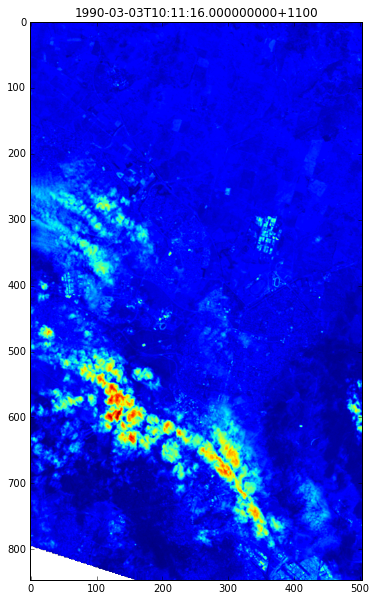

In [25]:
plt.imshow(WQ_TS_arr[0]); plt.title( L5_dates[0] )
WQ_TS_arr[0]

array([[ 1035. ,  1052.5,  1064. , ...,     nan,     nan,     nan],
       [  986. ,  1057.5,  1082.5, ...,     nan,     nan,     nan],
       [  898.5,  1001.5,  1059. , ...,     nan,     nan,     nan],
       ..., 
       [ 1803.5,  1603.5,  1419. , ...,   633. ,   676. ,   629.5],
       [ 1982. ,  1794.5,  1573. , ...,   562.5,   589.5,   637.5],
       [ 2071. ,  1897.5,  1688.5, ...,   600. ,   557. ,   512.5]])

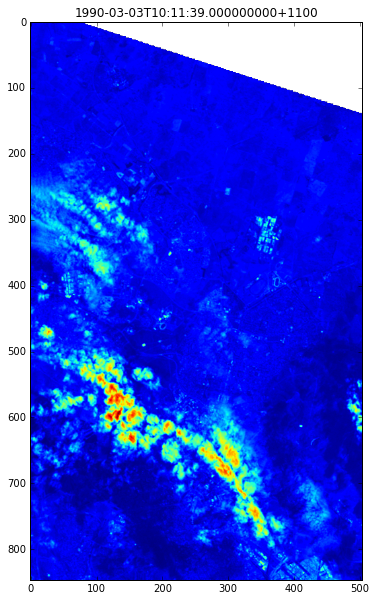

In [26]:
plt.imshow(WQ_TS_arr[1]); plt.title( L5_dates[1] )
WQ_TS_arr[1]

Here, the 2nd image has more NaN's than the first (same-day) image. So the following code should fill-in the NaN's in the first image with the data from the 2nd... Let's read a line to check this later:

In [27]:
one_line_from_image_before_fillin = WQ_TS_arr[0][600,:]

In [28]:
rem_ind = np.zeros(n_dates).astype('bool')   # keep track of which duplicated dates to remove

for ind in range(1,n_dates):
    dup_ind = np.where( strL5_dates[:ind]==strL5_dates[ind] )[0]   # check for duplicated date up to current index
    if len( dup_ind )!=0:   # found (at least) one duplicate
        dup_ind = dup_ind[0]   # only use the first index if multiple dates returned
        rem_ind[ind] = True    # remove current date index
        
        ind_n_nans = np.sum( np.isnan( WQ_TS_arr[ind] ) )   # nr of NaN pixels in each image
        dup_n_nans = np.sum( np.isnan( WQ_TS_arr[dup_ind] ) )
        
        if ind_n_nans==0:   # current data has no NaN's, use it instead of duplicate date (copy it to lowest index)
            WQ_TS_arr[dup_ind] = WQ_TS_arr[ind]
        elif dup_n_nans!=0:   # if duplicate date has no NaN's: do nothing (use it instead of current date)
            if dup_n_nans<ind_n_nans:   # duplicate date has less NaN's: fill it in with current data
                tmp = np.where( np.isnan(WQ_TS_arr[dup_ind]) )
                WQ_TS_arr[dup_ind][tmp] = WQ_TS_arr[ind][tmp]
            else:   # dup_n_nans>=ind_n_nans -- duplicate date has more NaN's: use it to fill in current data
                tmp = np.where( np.isnan(WQ_TS_arr[ind]) )
                WQ_TS_arr[ind][tmp] = WQ_TS_arr[dup_ind][tmp]
                WQ_TS_arr[dup_ind] = WQ_TS_arr[ind]   # save results to lowest date index

unique_WQ_TS_arr = WQ_TS_arr[~rem_ind]
unique_strL5_dates = strL5_dates[ ~rem_ind ]

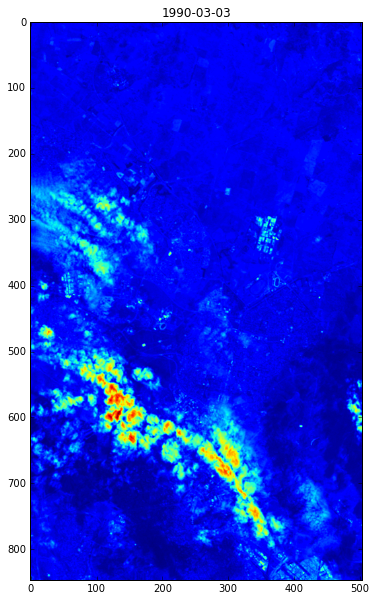

In [29]:
plt.imshow(unique_WQ_TS_arr[0]); plt.title( unique_strL5_dates[0] );

The above operation has obviously filled in the missing values in the image from the first occurence of date 1990-03-03. It should also have preserved the test line from that image:

In [30]:
( one_line_from_image_before_fillin==unique_WQ_TS_arr[0][600,:] ).all()

True

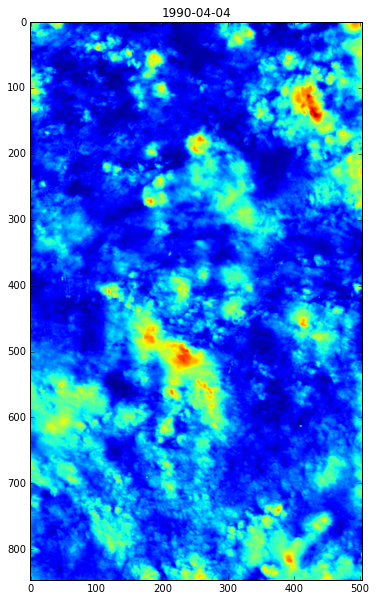

In [31]:
plt.imshow(unique_WQ_TS_arr[1]); plt.title( unique_strL5_dates[1] );